## Fundamentals of Machine Learning <br>
**Final Project Resit** <br>
Predict the time of the day when a Spotify track will be played based on your previous tracks' play time <br>
Gracie Becongco <br>

**Notebook Summary:** <br>
1. Data gathering: cronjob running every 4 hrs to extract my most recent play tracks using Spotify's Web API. Spotify retains only the last 50 tracks so a scheduled job must be used before Spotify overwrites the list. After data download, audio analytics was extracted for all tracks. <br>
 <br>
2. Data cleanup: dropped unneeded data. What remained is about 14 columns, consisting of audio analytics and Time of the Day played. Time of day played is based on track playtime. Rows where classified based on the following information: <br>
  1: Tracks played between 00:00 - 06:00hrs - Night <br>
  2: Tracks played between 06:01 - 12:00hrs - Morning  <br>
  3: Tracks played between 12:01 - 18:00hrs - Afternoon <br>
  4: Tracks played between 18:01 - 24:00hrs - Evening <br>
 <br>
3. Data exploration - data visualization<br>
 <br>
4. Machine Learning Model Testing Trial 1: <br>
  a. KN Neighbors Classifier <br>
  b. Random Forest Classifier  <br>
 <br>
5. Machine Learning Model Testing Trial 2 <br>
  a. KN Neighbors Classifier <br>
  b. Random Forest Classifier  <br>
 <br>
6. Conclusion


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize  
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import tree

from datetime import datetime
from math import sqrt

##  <font color='blue'> 1. Data Gathering <font>

1. Data gathering: cronjob running every 4 hrs to extract the last 50 recently played tracks using Spotify's Web API. Spotify retains only the last 50 tracks so a scheduled job must be used before Spotify overwrites the list. After data download, audio analytics was extracted for all tracks. A 2nd program was run to merge data from the ones previously gathered into a single file as input for the prediction models. <br>

In [2]:
#####################################################################
# Python Program 1
# Get most recent tracks played data from Spotify Web API
#####################################################################
#import pandas as pd
#import spotipy as spy
#from spotipy.oauth2 import SpotifyOAuth
#from datetime import datetime
#import time

#datastorage='/Users/gracie/JupyterNB/spotify/data/'
#mainfile='/Users/gracie/JupyterNB/spotify/data/mainfile_spotify.csv'
#mfcsv=pd.read_csv(mainfile)
#maindf=pd.DataFrame(mfcsv)
#maindf.drop(['Unnamed: 0'], axis = 1, inplace = True)
#print('Main datafile for storage loaded: '+mainfile)
#print(maindf.info())
##Credentials
#username = "divisiblebyzer0"
#client_id="*************"
#client_secret="**********************************"
#redirect_uri = "http://localhost:8080/auth/external/callback/"
#scope = "user-read-recently-played user-read-playback-position user-top-read user-read-playback-state user-read-currently-playing user-library-read"

#####################################################################
# extract most recent songs from user Spotify Account
#####################################################################
#sp = spy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,client_secret=client_secret, redirect_uri=redirect_uri, scope=scope))
#recent_songs = sp.current_user_recently_played(limit=50)
#####################################################################
# get track ID and play time from spotify data
#####################################################################
#myrecent = []
#mynow=datetime.now()
#pull_date=mynow.strftime("%Y.%m.%d %H:%M")
#for idx, item in enumerate(recent_songs['items']):
#    track = item['track']
#    mystr = item['played_at']
#    mystr2 = mystr.replace("T", " ")
#    mystring = mystr2[0:16]
#    recent_items = [idx, track['id'], mystring, pull_date]
#    myrecent.append(recent_items)


#####################################################################
# save extracted recently played tracks data to disk as backup
#####################################################################
#df=pd.DataFrame(myrecent)
#now=datetime.now()
#dt_string = now.strftime("%Y.%m.%d.t%H.%M.%S")
#df.to_csv(datastorage+dt_string+'.spotify.tracksid.csv')

############################################################################
# Function to extract audio features of the most recently played tracks
############################################################################
#def get_track_data(track_id):
#    meta = sp.track(track_id)
#    af = sp.audio_features(track_id)
#    af_df = pd.DataFrame.from_records(af)
#    track_details = {"track_id":track_id,
#                     "name": meta['name'],
#                     "album":meta['album']['name'],
#                     "artist": meta['album']['artists'][0]['name'],
#                     "release_date": meta['album']['release_date'],
#                     "duration_in_mins": round((meta['duration_ms']*0.001)/60.0,2),
#                     "acousticness": af_df['acousticness'].loc[0].astype(float, copy=True),
#                     "analysis_url": af_df['analysis_url'].loc[0],
#                     "danceability": af_df['danceability'].loc[0].astype(float, copy=True),
#                     "energy": af_df['energy'].loc[0].astype(float, copy=True),
#                     "instrumentalness": af_df['instrumentalness'].loc[0].astype(float, copy=True),
#                     "key": af_df['key'].loc[0].astype(int, copy=True),
#                     "liveness": af_df['liveness'].loc[0].astype(float, copy=True),
#                     "loudness": af_df['loudness'].loc[0].astype(float, copy=True),
#                     "mode": af_df['mode'].loc[0],
#                     "speechiness": af_df['speechiness'].loc[0].astype(float, copy=True),
#                     "tempo": af_df['tempo'].loc[0].astype(float, copy=True),
#                     "time_signature": af_df['time_signature'].loc[0].astype(int, copy=True),
#                     "track_href": af_df['track_href'].loc[0],
#                     "type": af_df['type'].loc[0],
#                     "uri": af_df['uri'].loc[0],
#                     "valence": af_df['valence'].loc[0].astype(float, copy=True),}
#    return track_details

############################################################################
# Reset index and rename columns
############################################################################
#df.reset_index()
#df.columns=['index','track_id','play_time','extraction_date']

############################################################################
# Assign tracks to series to be used to extract audio analysis
############################################################################
#trx_ids = pd.Series(df['track_id'])

############################################################################
# Extract audio analysis for each track ID and save to dataframe
############################################################################
#trackx = []
#for i in range(len(trx_ids)):
#    if not(trx_ids[i] is None):
#        time.sleep(.5)
#        track = get_track_data(trx_ids[i])
#        trackx.append(track)

############################################################################
# Audio analysis extracted. Now assign to dataframe and merge
############################################################################
#trackx_df=pd.DataFrame(trackx)
#dfmerge=pd.merge(df,trackx_df, on='track_id')
#print('Details of merged data: \n')
#print(dfmerge.info())
##remove extra index columns
#dfmerge.drop([0], inplace=True)
#dfmerge2=pd.DataFrame(dfmerge)
#dfmerge2.to_csv(datastorage+dt_string+'.merged.spotify.csv')
#print("\n Details of merged dataframes to be appended to the main: ")
#print(dfmerge2.info())

#######################################################################
# append extracted data to main storage file
#######################################################################
#maindf = maindf.append(dfmerge2,ignore_index=True)
#maindf.drop(['extraction_date'], axis=1, inplace=True)
#maindf.drop_duplicates(inplace=True)
#print('\n Main dataframe info and data: ')
#print(maindf.info())
#maindf.to_csv(mainfile)
#now=datetime.now()
#dt_string = now.strftime("%Y.%m.%d.t%H.%M.%S")
#print('Completed Spotify data extraction '+dt_string)
#######################################################################
# END
#######################################################################


#######################################################################
# Python Program 2
# Process and merge data
#######################################################################
#import pandas as pd
#import spotipy as spy
#from spotipy.oauth2 import SpotifyOAuth
#from datetime import datetime
#import time

#datastorage='/Users/gracie/JupyterNB/spotify/data/'
#newdatastorage='/Users/gracie/JupyterNB/spotify_resit/data/'
#mainfile='mainfile_spotify.csv'
#mfcsv=pd.read_csv('/Users/gracie/JupyterNB/spotify/data/'+mainfile)
#maindf=pd.DataFrame(mfcsv)
#maindf.drop(['Unnamed: 0'], axis = 1, inplace = True)
#print('Main datafile for storage loaded: '+mainfile)
#print(maindf.info())
##Credentials
#username = "divisiblebyzer0"
#client_id="******************"
#client_secret="************************"
#redirect_uri = "http://localhost:8080/auth/external/callback/"
#scope = "user-read-recently-played user-read-playback-position user-top-read user-read-playback-state user-read-currently-playing user-library-read"

#####################################################################
# extract most recent songs from user Spotify Account
#####################################################################
#sp = spy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,client_secret=client_secret, redirect_uri=redirect_uri, scope=scope))
#recent_songs = sp.current_user_recently_played(limit=50)
#####################################################################
# get track ID and play time from spotify data
#####################################################################
#myrecent = []
#mynow=datetime.now()
#pull_date=mynow.strftime("%Y.%m.%d %H:%M")
#for idx, item in enumerate(recent_songs['items']):
#    track = item['track']
#    mystr = item['played_at']
#    mystr2 = mystr.replace("T", " ")
#    mystring = mystr2[0:16]
#    recent_items = [idx, track['id'], mystring, pull_date]
#    myrecent.append(recent_items)

#####################################################################
# save extracted recently played tracks data to disk as backup
#####################################################################
#df=pd.DataFrame(myrecent)
#now=datetime.now()
#dt_string = now.strftime("%Y.%m.%d.t%H.%M.%S")
#df.to_csv(newdatastorage+dt_string+'.spotify.tracksid.csv')

############################################################################
# Function to extract audio features of the most recently played tracks
############################################################################
#def get_track_data(track_id):
#    meta = sp.track(track_id)
#    af = sp.audio_features(track_id)
#    af_df = pd.DataFrame.from_records(af)
#    track_details = {"track_id":track_id,
#                     "name": meta['name'],
#                     "album":meta['album']['name'],
#                     "artist": meta['album']['artists'][0]['name'],
#                     "release_date": meta['album']['release_date'],
#                     "duration_in_mins": round((meta['duration_ms']*0.001)/60.0,2),
#                     "acousticness": af_df['acousticness'].loc[0].astype(float, copy=True),
#                     "analysis_url": af_df['analysis_url'].loc[0],
#                     "danceability": af_df['danceability'].loc[0].astype(float, copy=True),
#                     "energy": af_df['energy'].loc[0].astype(float, copy=True),
#                     "instrumentalness": af_df['instrumentalness'].loc[0].astype(float, copy=True),
#                     "key": af_df['key'].loc[0].astype(int, copy=True),
#                     "liveness": af_df['liveness'].loc[0].astype(float, copy=True),
#                     "loudness": af_df['loudness'].loc[0].astype(float, copy=True),
#                     "mode": af_df['mode'].loc[0],
#                     "speechiness": af_df['speechiness'].loc[0].astype(float, copy=True),
#                     "tempo": af_df['tempo'].loc[0].astype(float, copy=True),
#                     "time_signature": af_df['time_signature'].loc[0].astype(int, copy=True),
#                     "track_href": af_df['track_href'].loc[0],
#                     "type": af_df['type'].loc[0],
#                     "uri": af_df['uri'].loc[0],
#                     "valence": af_df['valence'].loc[0].astype(float, copy=True),}
#    return track_details

############################################################################
# Reset index and rename columns
############################################################################
#df.reset_index()
#df.columns=['index','track_id','play_time','extraction_date']

############################################################################
# Assign tracks to series to be used to extract audio analysis
############################################################################
#trx_ids = pd.Series(df['track_id'])

############################################################################
# Extract audio analysis for each track ID and save to dataframe
############################################################################
#trackx = []
#for i in range(len(trx_ids)):
#    if not(trx_ids[i] is None):
#       time.sleep(.5)
#        track = get_track_data(trx_ids[i])
#        trackx.append(track)

############################################################################
# Audio analysis extracted. Now assign to dataframe and merge
############################################################################
#trackx_df=pd.DataFrame(trackx)
#dfmerge=pd.merge(df,trackx_df, on='track_id')
#print('Details of merged data: \n')
#print(dfmerge.info())
##remove extra index columns
#dfmerge.drop([0], inplace=True)
#dfmerge2=pd.DataFrame(dfmerge)
#dfmerge2.to_csv(newdatastorage+dt_string+'.merged.spotify.csv')
#print("\n Details of merged dataframes to be appended to the main: ")
#print(dfmerge2.info())

#######################################################################
# append extracted data to main storage file
#######################################################################
#maindf = maindf.append(dfmerge2,ignore_index=True)
#maindf.drop(['Unnamed: 0.1', 'index'], axis=1, inplace=True)
#maindf.drop_duplicates(inplace=True)
#print('\n Main dataframe info and data: ')
#print(maindf.info())
#maindf.to_csv(newdatastorage+mainfile)
#now=datetime.now()
#dt_string = now.strftime("%Y.%m.%d.t%H.%M.%S")
#print('Completed Spotify data extraction '+dt_string)
#######################################################################
# END
#######################################################################

##  <font color='blue'> 2. Data Cleanup <font>

2. Data cleanup: dropped unneeded data. What remained is about 14 columns, consisting of audio analytics and Time of the Day played. Time of day played is based on track playtime. Rows where classified based on the following information: <br>
1: Tracks played between 00:00 - 06:00hrs - Night <br>
2: Tracks played between 06:01 - 12:00hrs - Morning  <br>
3: Tracks played between 12:01 - 18:00hrs - Afternoon <br>
4: Tracks played between 18:01 - 24:00hrs - Evening <br><br>

In [3]:
#import pandas as pd

#####################################################################
# Location of files/Loading of files
#####################################################################
#loc = '/Users/gracie/JupyterNB/spotify_resit/data/'
## file below is the file sent by Spotify
#summfile='StreamingHistory_searchinfo_base_merged.csv'
## file below is the file from the cronjob
#currentf='/Users/gracie/JupyterNB/spotify/data/mainfile_spotify.csv'
#currcsv = pd.read_csv(currentf,parse_dates=['play_time'])
#df = pd.DataFrame(currcsv)
#####################################################################
# Drop unnecessary columns and duplicates
#####################################################################
#df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)
#print(df.info())
#df_all = df.copy()
#print(df_all.info())
#df_all.drop_duplicates(inplace=True)
#df_all.drop(['index'], axis=1, inplace=True)
#print(df_all.info())

#####################################################################
# create new data: play time in integer format and day played
#####################################################################
#df_all['day_played'] = df_all['play_time'].dt.day_name()
#df_all['day_played_int'] = df_all['play_time'].dt.dayofweek

#####################################################################
# create new data: play time convert to labels 
#  1: Night
#  2: Morning
#  3: Afternoon
#  4: Evening
# create weekend/weekday column
#####################################################################
#df_all['time_of_day'] = pd.cut(pd.to_datetime(df_all.play_time).dt.hour,
#       bins=[0, 6, 12, 18, 24],
#       labels=['1', '2', '3', '4'],
#       right=False,
#       include_lowest=True)
#df_all['time_of_day'].astype(int)
#print(df_all.head())
#df_all.to_csv(loc+'allspotify_merged_final.csv')
#df_all['daytype']=''
#for index, row in df_all.iterrows():
#       if df_all.at[index, 'day_played'] in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
##              df_all.at[index, 'daytype'] = 'Weekday'
#       else: df_all.at[index, 'daytype'] = 'Weekend'
#df_all.sort_values(by=['play_time'])
#df_all.to_csv(loc+'allspotify_merged_final.csv')

########################################################
#Part 2: Generate file variations and do further
# cleanup after saving the file for safekeeping
########################################################
#mfile=loc+'allspotify_merged_final.csv'
#csv = pd.read_csv(mfile, parse_dates=['play_time'])
#df1 = pd.DataFrame(csv)

########################################################
# Cleanup: drop unneeded files, drop duplicates
########################################################
#df1.drop(['Unnamed: 0', 'track_id','analysis_url','track_href','type','uri','release_date','album'], axis=1, inplace=True)
#df1.drop_duplicates(inplace=True)
#df1.dropna(axis = 1)
#df1.drop_duplicates(inplace=True)
#df1.reset_index()

########################################################
# copy all non-null data in the dataframe to a new dataframe
########################################################
#df2 = df1[~df1.name.isnull()].copy()
#print(df2.isnull().sum())

########################################################
# convert date to timestamp integer value
########################################################
#df2['dateval'] = df2[['play_time']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)  # convert date time to integer
#print(df2.info())

########################################################
# save to datafile as backup containing ALL data, in 
# case we need to doublecheck if data was incorrectly processed
########################################################
#df2.to_csv(loc+'allspotify_merged_final_nonull.csv')

########################################################
# get dummies
########################################################
#dum2=pd.get_dummies(df2["daytype"])

########################################################
# DROP ALL UNNEEDED COLUMNS
########################################################
#df2.drop(['daytype','play_time','name','artist','day_played', 'daytype','day_played_int'], axis=1, inplace=True)
#print(df2.info())
#print(df2.head())

########################################################
# save to file, this is going to be a candidate for 
# final processing, contains less columns
########################################################
#df2.drop_duplicates(inplace=True)
#df2.to_csv(loc+'allspotify_merged_final_nonull2.csv')

# variation of dataframe that contaims all variables
#df = pd.concat([df2, dum2], axis=1)
#df.drop(['Weekend','Weekday'], axis=1, inplace=True)
#df.drop_duplicates(inplace=True)
#df.to_csv(loc+'allspotify_merged_final_nonull_allvars2.csv')
########################################################
# END
########################################################


Load dataset. This run we will be using only audio analytics (valence, acousticness, energy, loudness, etc.) and time of day column (morning, afternoon, evening, night). All other columns will be removed.

In [4]:
dfile='/Users/gracie/JupyterNB/spotify_resit/data/allspotify_merged_final_nonull2.csv'
csv=pd.read_csv(dfile)
df=pd.DataFrame(csv)
df.drop(['Unnamed: 0','dateval'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3855 entries, 0 to 3854
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_in_mins  3855 non-null   float64
 1   acousticness      3855 non-null   float64
 2   danceability      3855 non-null   float64
 3   energy            3855 non-null   float64
 4   instrumentalness  3855 non-null   float64
 5   key               3855 non-null   int64  
 6   liveness          3855 non-null   float64
 7   loudness          3855 non-null   float64
 8   mode              3855 non-null   int64  
 9   speechiness       3855 non-null   float64
 10  tempo             3855 non-null   float64
 11  time_signature    3855 non-null   int64  
 12  valence           3855 non-null   float64
 13  time_of_day       3855 non-null   int64  
dtypes: float64(10), int64(4)
memory usage: 421.8 KB


We have 14 columns and 3855 rows in the dataset. <br>
We will now move to exploring the data we have.

## <font color='blue'> 3. Data exploration - data visualization <font>

## Exploratory Data Analysis

List the record counts we have in the dataframe based on time of day played. We need to check that there is indeed data for each of the labels. <br>
Label is designed as follows: <br>
1: Tracks played between 00:00 - 06:00hrs - Night  <br>
2: Tracks played between 06:01 - 12:00hrs - Morning  <br>
3: Tracks played between 12:01 - 18:00hrs - Afternoon  <br>
4: Tracks played between 18:01 - 24:00hrs - Evening  <br>

In [5]:
print(df.groupby(['time_of_day']).size())

time_of_day
1     515
2     388
3    1332
4    1620
dtype: int64


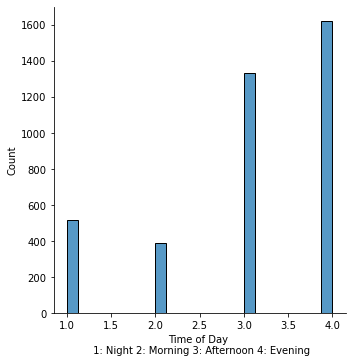

In [6]:
sns.displot(df, x="time_of_day", facet_kws=dict(margin_titles=True), )
plt.xlabel("Time of Day \n 1: Night 2: Morning 3: Afternoon 4: Evening")
plt.show()

Based on the number and distribution plot above, I listen to a lot of music usually in the afternoon and evening. Most importantly, the data above shows that there is data for all the labels we have defined. This ensures that there is data to train for each label. 

Just out of curiosity, we list most recurring tracks on record including count based on the previous version of the data which includes the track names. 

In [7]:
tracks='/Users/gracie/JupyterNB/spotify_resit/data/allspotify_merged_final_nonull.csv'
tcsv=pd.read_csv(tracks)
tdf=pd.DataFrame(tcsv)
tracksdeets=tdf[["artist","name"]]
occurgrp = tracksdeets.groupby(['artist','name']).size().sort_values(ascending=False)
occur_df=occurgrp.to_frame()
print('Top 10 Most Played Tracks \n')
print(occur_df.head(10))

Top 10 Most Played Tracks 

                                                               0
artist          name                                            
Al Green        Let's Stay Together                           39
The Temptations My Girl                                       36
The Supremes    Baby Love                                     32
Bill Withers    Ain't No Sunshine                             27
Otis Redding    Try a Little Tenderness                       26
The Real Thing  You To Me Are Everything                      25
The Supremes    You Can't Hurry Love                          24
Four Tops       I Can't Help Myself (Sugar Pie, Honey Bunch)  24
Various Artists (Sittin' On) the Dock of the Bay              21
Johnny Nash     I Can See Clearly Now - Edit                  21


# Data Correlation <br>
Identify which data is correlated so we know which columns to be used in visualizing the data

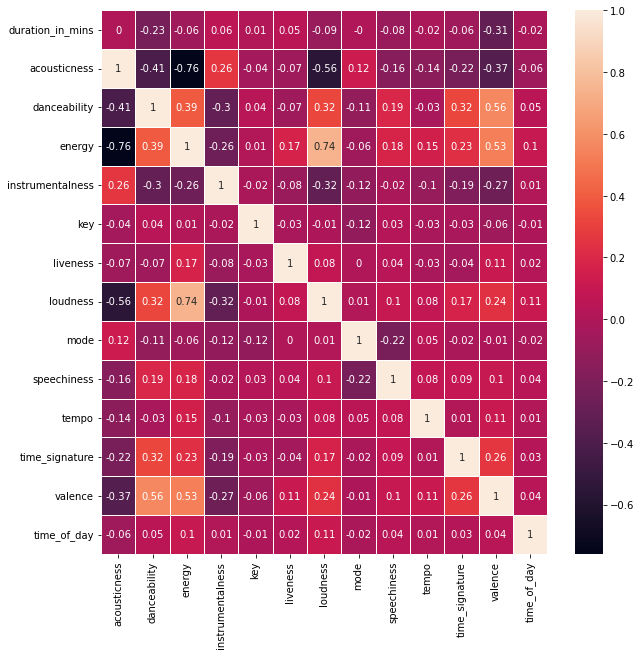

In [8]:
df_corr_matrix = df.corr().round(2)  
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df_corr_matrix.iloc[:, 1:14:], annot=True, linewidths=.5, ax=ax)
plt.show()

Based on the correlation matrix above, valence, energy, loudness and danceability are the variables that seems to have the most correlation so we will try to visualize the data.

**Data Visualization** <br>
<br>
Valence vs other correlated data <br>


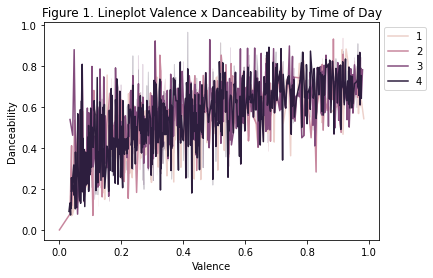

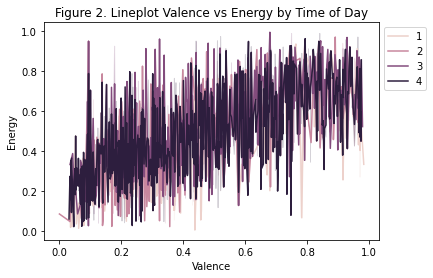

In [9]:
sns.lineplot(x="valence", y="danceability",hue="time_of_day", data=df)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Figure 1. Lineplot Valence x Danceability by Time of Day')
plt.xlabel("Valence")
plt.ylabel("Danceability")
plt.show()

sns.lineplot(x="valence", y="energy",hue="time_of_day", data=df)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Figure 2. Lineplot Valence vs Energy by Time of Day')
plt.xlabel("Valence")
plt.ylabel("Energy")
plt.show()


Lineplot of Loudness vs. Energy by Time of Day 

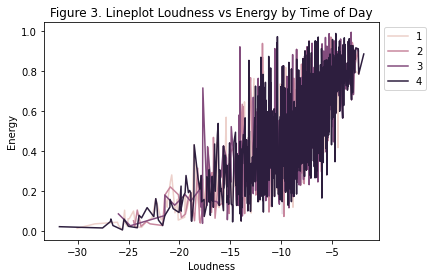

In [10]:
sns.lineplot(x="loudness", y="energy",hue="time_of_day", data=df)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('Figure 3. Lineplot Loudness vs Energy by Time of Day')
plt.xlabel("Loudness")
plt.ylabel("Energy")
plt.show()

**Observations:** <br>
_Figure 1, 2:_ As valence increases, so does energy and danceability <br>
_Figure 3:_ As Loudness increases, energy increases as well <br>
This seems to be an inherent property of music. More danceable music does have more energy. Louder tracks has increased energy as well.  

Line Plot Time of Day vs other data

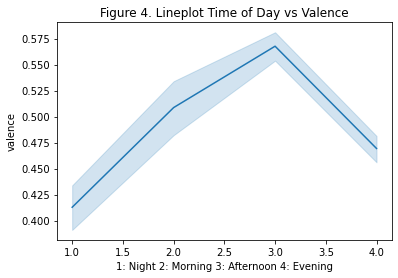

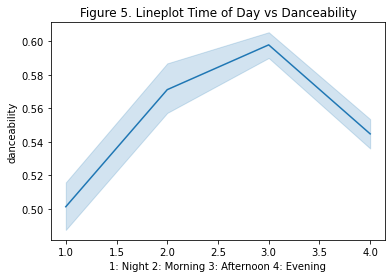

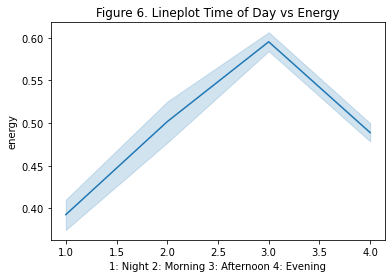

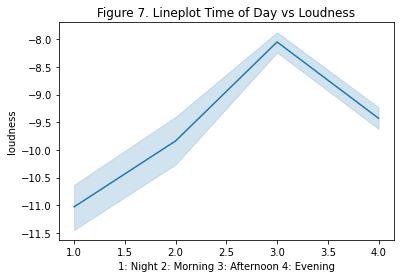

In [11]:
sns.lineplot(x="time_of_day", y="valence", data=df)
plt.title('Figure 4. Lineplot Time of Day vs Valence')
plt.xlabel("1: Night 2: Morning 3: Afternoon 4: Evening")
plt.show()

sns.lineplot(x="time_of_day", y="danceability", data=df)
plt.title('Figure 5. Lineplot Time of Day vs Danceability')
plt.xlabel("1: Night 2: Morning 3: Afternoon 4: Evening")
plt.show()

sns.lineplot(x="time_of_day", y="energy", data=df)
plt.title('Figure 6. Lineplot Time of Day vs Energy')
plt.xlabel("1: Night 2: Morning 3: Afternoon 4: Evening")
plt.show()

sns.lineplot(x="time_of_day", y="loudness", data=df)
plt.title('Figure 7. Lineplot Time of Day vs Loudness')
plt.xlabel("1: Night 2: Morning 3: Afternoon 4: Evening")
plt.show()

**Observations:** <br>
_Figure 4:_ Valence indicates musical positiveness of the tracks played. The lineplot indicates that most postive tracks are played during the afternoon. Valence of tracks I listen to increases from night to morning ,peaks at afternoons, and decreases from afternoon to evening <br>
_Figure 5:_ Tracks with higher danceability is played from morning to afternoon and decreases until the evening <br>
_Figure 6 and 7:_ Almost identical with most energetic and loud tracks played in the afternoon. Tracks played in the morning increases in  energy/loudness until the afternoon and then decreases in the evening <br>
Those 4 figures indicates that I tend to listen to the most positive, danceable and energetic songs in the afternoon. 

**Distribution plots with various variables with respect to dependent variable (Time of Day)**

Figure 8. Distribution Plot: Valence vs Time of Day 
 1: Night 2: Morning 3: Afternoon 4: Evening


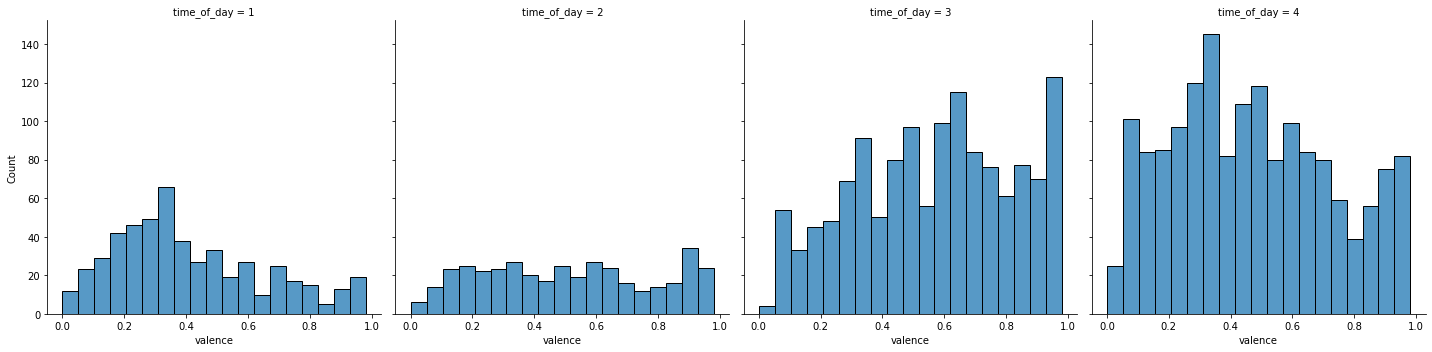

In [12]:
print('Figure 8. Distribution Plot: Valence vs Time of Day \n 1: Night 2: Morning 3: Afternoon 4: Evening')
sns.displot(df, x="valence", col="time_of_day", facet_kws=dict(margin_titles=True), )
plt.show()

Figure 9. Distribution Plot: Energy vs Time of Day 
 1: Night 2: Morning 3: Afternoon 4: Evening


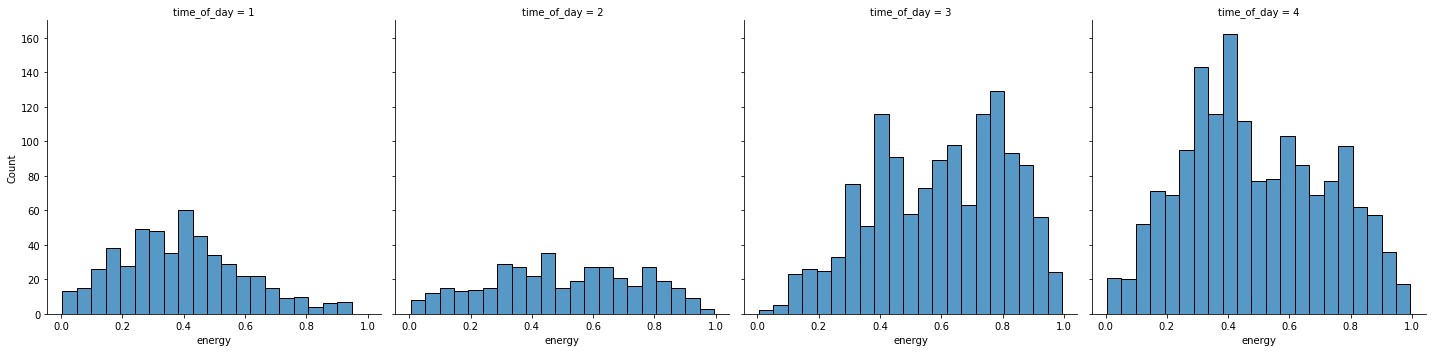

In [13]:
print('Figure 9. Distribution Plot: Energy vs Time of Day \n 1: Night 2: Morning 3: Afternoon 4: Evening')
sns.displot(df, x="energy", col="time_of_day", facet_kws=dict(margin_titles=True), )
plt.show()

Figure 10. Distribution Plot: Danceability vs Time of Day 
 1: Night 2: Morning 3: Afternoon 4: Evening


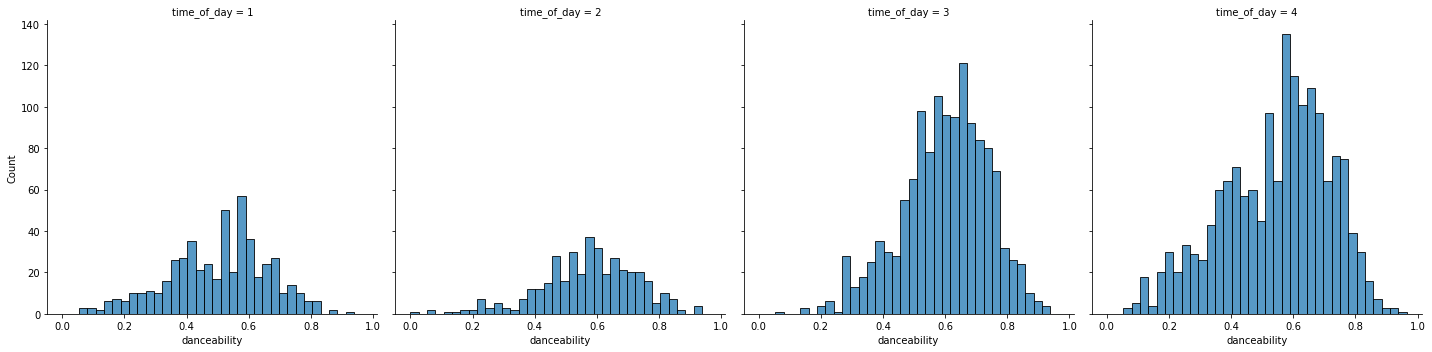

In [14]:
print('Figure 10. Distribution Plot: Danceability vs Time of Day \n 1: Night 2: Morning 3: Afternoon 4: Evening')
sns.displot(df, x="danceability", col="time_of_day" )
plt.show()

Figure 11. Distribution Plot: Loudness vs Time of Day 
 1: Night 2: Morning 3: Afternoon 4: Evening


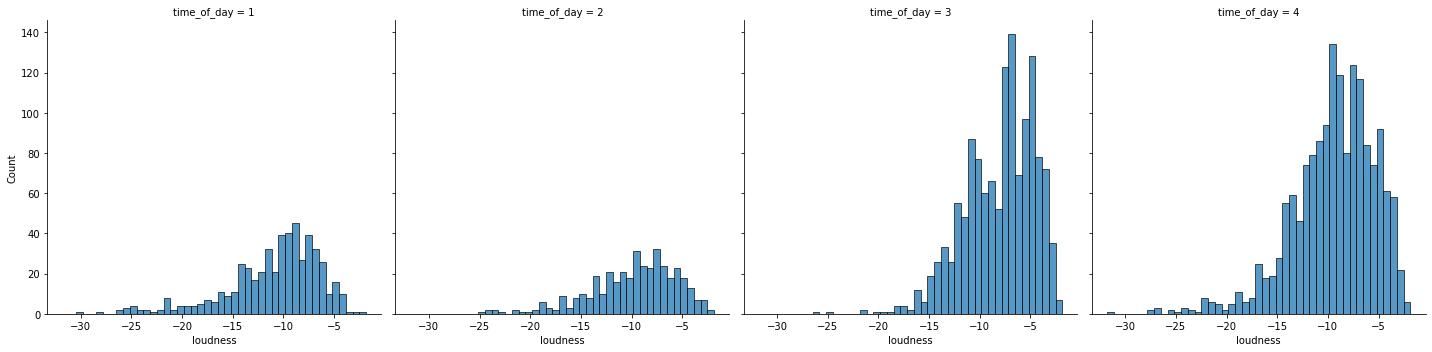

In [15]:
print('Figure 11. Distribution Plot: Loudness vs Time of Day \n 1: Night 2: Morning 3: Afternoon 4: Evening')
sns.displot(df, x="loudness", col="time_of_day" )
plt.show()

**Observations Summary:** <br>
Figures 1, 2, 3 indicates inherent properties of music and does not pertain to any observations to my usage. It shows valence is proportional to energy and danceability, and loudnes is proportional to energy. <br>
<br>
Observations to my usage is apparent on Figures 4,5,6 and 7. It shows that after midnight (labelled as "night") I listen to music that increases in valence, loudness, energy, and danceability as the day progresses and peaks in the afternoon. Afterwhich I tend to listen to tracks are lower in terms of valence, loudness, energy, and danceability well into the evening. <br>
<br>
Figures 8 to 11 supports observations seen on figures 4-7. Extremes (high values) of plotted x-variables (energy, loudness, valence, danceability) are present in the afternoon and evening labels (3, 4) only.


##  <font color='blue'> 4. Machine Learning Trial 1 <font>

## KNeighborsClassifier Trial 1

Split data to 70% training and 30% test data. <br>
X has been normalized <br>

In [16]:
df['time_of_day'].astype(int)
X = df.drop('time_of_day',axis=1)
X = normalize(X)
y = df['time_of_day'].astype(int)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=40)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)


Try to identify the best n_neighbors parameter <br>
Test for n_neighbors parameter from 1 to 100 and plot the error rates results to see which is the best parameter

In [17]:
error_rate = []
maxpred = 0
maxi = 0 
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

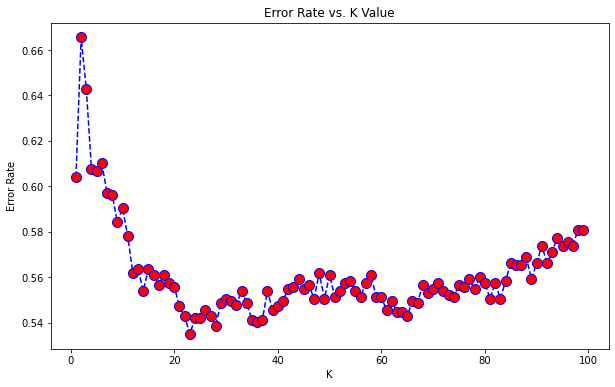

In [18]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Based on the graph above, the n_neighbors value where the lowest errors congregate somewhere in between 20 and 30. So we choose n_neighbors=23 for the knn model.

In [19]:
knn = KNeighborsClassifier(n_neighbors=23)  
knn = knn.fit(X_train, y_train)            # fit the k-nearest neigbor model with the train data
kscore = knn.score(X_test, y_test)                  # calculate the fit on the test data
print('KNN fit score of test data is '+str(kscore))

KNN fit score of test data is 0.46499567847882456


At n_neighbors=23, the KNN fit score of test data is 0.4650 <br>
Let us now compute for the confusion matrix and precision/recall <br>

                  Night_pred  Morning_pred  Afternoon_pred  Evening_pred
Actual_Night               3             0              39           118
Actual_Morning             1             0              44            73
Actual_Afternoon           4             1             232           170
Actual_Evening             3             1             165           303
              precision    recall  f1-score   support

           1       0.27      0.02      0.04       160
           2       0.00      0.00      0.00       118
           3       0.48      0.57      0.52       407
           4       0.46      0.64      0.53       472

    accuracy                           0.46      1157
   macro avg       0.30      0.31      0.27      1157
weighted avg       0.39      0.46      0.41      1157



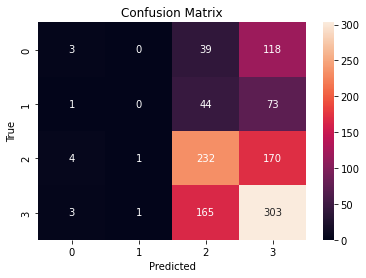

In [20]:
    y_test_pred = knn.predict(X_test) #the predicted values
    cmat = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
    sns.heatmap(cmat, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    conf_matrix = pd.DataFrame(cmat, index=['Actual_Night','Actual_Morning','Actual_Afternoon','Actual_Evening'], columns = ['Night_pred','Morning_pred','Afternoon_pred','Evening_pred']) 
    print(conf_matrix)
    print(classification_report(y_test,y_test_pred, zero_division=0))


In [21]:
test_preds = knn.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
print('R-squared: '+str(kscore))
print('RMSE for test data. \n')
print('RMSE: '+ str(round(rmse,5)))

R-squared: 0.46499567847882456
RMSE for test data. 

RMSE: 1.29423


KNeighborsClassifier model has an accuracy of 0.46499 implying it can predict the label of a track correctly 46.50% of the time. Precision per y-label (night, morning,afternoon, evening) is low from 0.00 to 0.48 indicates that 0% to 48%  of predicted tracks' play time are correctly predicted. Recall looks low as well, with a range of 0.00 to 0.64 indicating that 0% to 64% of the track-play time is predicted correctly with the KNN model. <br> <br>
Note that the model has a precision and recall of 0 for label 2 which are tracks played in the morning. If you look at the confusion matrix, there are 0 actual morning tracks in the test dataset but the model predicted 2 tracks as morning tracks indicating that it has failed predicting morning tracks. <br>
<br>
R-squared indicates that we can explain 46.5% of the variation <br>
RMSE indicates that prediction is typically off by 1.29 <br>
<br>
We will now try to see how a Random Forest Classifier performs with my data. <br>

## Random Forest Classifier Trial 1

Use a Random Forest Classifier to fit the data using default parameters. <br>
The train-test split has been stratified so that the proportion of time of day (y) values in the sample produced in the train set will be the same as the proportion of values provided in the test set.

In [22]:
X = df.drop('time_of_day',axis=1)
y = df['time_of_day'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=40)

# use standard scaler to scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Create the model, train it with the train data and test for accuracy using the test data. Default parameters are used.

In [23]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred_test = forest.predict(X_test)
score = accuracy_score(y_test, y_pred_test)
print(score)

0.4312878133102852


In [24]:
print('R-squared: '+str(score))
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE: '+ str(round(rmse,5)))

R-squared: 0.4312878133102852
RMSE: 1.36286


The RandomForestClassifier model's R-squared indicates that we can explain 43.04% of the variation of the model. RMSE indicates that the model's prediction is off by 1.34. Like KNN, results are low. Let us see if we can tune the parameters and improve the accuracy<br>
We try to tune by using Grid Search or Halving Grid Search to produce the best parameters. 

Run the experimental HalvingGridSearchCV to get the best parameters for the RandomForestClassifier model. This runs faster than the GridSearchCV. <br>
The code below was run in PyCharm as it runs a long time and causes Jupyter Notebook to crash

In [25]:
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import HalvingGridSearchCV
#from sklearn.preprocessing import normalize

#dfile='/Users/gracie/JupyterNB/spotify_resit/data/allspotify_merged_final_nonull2.csv'
#csv=pd.read_csv(dfile)
#df=pd.DataFrame(csv)
#df.info()
#df.drop(['Unnamed: 0'], axis=1, inplace=True)
#X = df.drop('time_of_day',axis=1)
#feature_names = X.columns.tolist()
#X = normalize(X)
#y = df['time_of_day'].astype(int)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=40)
#print(y.value_counts())
#clf = RandomForestClassifier()

# 1/2 GridSearchCV
#param_grid = {
#    'bootstrap': ['True','False'],
#    'criterion': ['gini', 'entropy'],
#    'max_depth': [12, 13, 14,15,16,17,18],
#    'max_features': ['auto', 'log2', 'sqrt', None],
#    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900],
#    'oob_score': ['True','False'],
#    'warm_start': ['True','False']
#}


#search = HalvingGridSearchCV(clf, param_grid,
#                             max_resources='auto', cv=3, verbose=3, n_jobs=-1,
#                             random_state=1).fit(X_train, y_train)
#print(search.best_params_)



The HalvingGridSearchCV determined that the best parameters to use in our RandomForestClassifier is the following: <br>
bootstrap=False <br>
criterion='gini' <br>
max_depth=13 <br>
max_features='log2' <br>
n_estimators=750 <br>
oob_score=False <br>
warm_start=True <br>
random_state=1 <br>
 <br>
Using the best parameters to run the RandomForestClassifier model and see if the accuracy scores improves

In [26]:
forest_hgs = RandomForestClassifier(bootstrap=False,criterion='gini',max_depth=13,max_features='log2',n_estimators=750,oob_score=False,warm_start=True)
forest_hgs.fit(X_train, y_train)
y_pred_test = forest_hgs.predict(X_test)
score = accuracy_score(y_test, y_pred_test)
print(score)

0.43301642178046673


In [27]:
print('R-squared: '+str(score))
ypred = forest.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE: ", rmse) 

R-squared: 0.43301642178046673
RMSE:  1.3408030463079819


The Random Forest Classifier model with the optimal parameters yielded only an accuracy score of 0.43820224719101125. The R-squared value indicates that the model can only explain 43.82% of the variation of the prediction. RMSE indicates that prediction is usually off by 1.34

              precision    recall  f1-score   support

           1       0.33      0.14      0.19       155
           2       0.19      0.08      0.11       116
           3       0.47      0.44      0.45       400
           4       0.44      0.61      0.51       486

    accuracy                           0.43      1157
   macro avg       0.36      0.32      0.32      1157
weighted avg       0.41      0.43      0.41      1157



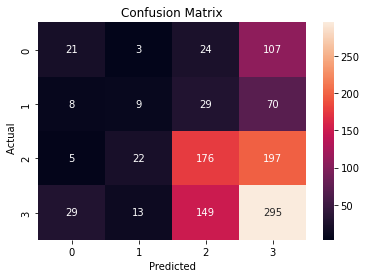

In [28]:
cmat = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cmat, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual    ')
print(classification_report(y_test,y_pred_test, zero_division=0))

conf_matrix = pd.DataFrame(cmat, index=['Actual_Night','Actual_Morning','Actual_Afternoon','Actual_Evening'], columns = ['Night_pred','Morning_pred','Afternoon_pred','Evening_pred']) 
#print(conf_matrix)
#print(classification_report(y_test,y_test_pred, zero_division=0))

Precision per y-label (night, morning,afternoon, evening) is low from 0.17 to 0.48 indicates that 17% to 48% of predicted tracks' play time are correctly predicted. Recall looks low as well, with a range of 0.07 to 0.61 indicating that 7% to 61% of the track-play time is predicted correctly with the RandomForestClassifier model. <br>
<br>

**Summary of the models first trial run performance below:** <br>
<table >
<tr><th>Classifier Models<th><th> R2 <th><th> RMSE  <th><th> Precision/Recall Weighted Avg<tr><tr>
<tr><td> KNeighborsClassifier <td><td> 0.4650 <td><td> 1.29423 <td><td> 0.39/0.46 <td><tr>
<tr><td> RandomForestClassifier <td><td> 0.4330 <td><td> 1.34080 <td><td> 0.41/0.43 <td><tr>
<table>

K-Neighbor Classifier model has the better accuracy score. But if you look at the precision/recall numbers, the model fails to do predictions for morning tracks (label 2). Though the Random Forest Classifier has a lower accuracy score, the precision and recall numbers are much better and can produce predictions for morning played tracks (value greater than zero). For this run, the Random Forest Classifier model is preferable despite the lower accuracy since precision/recall metrics seems much better. 

Both models performed poorly. Let us try to add another parameter to the dataset (dateval which is an integer value of the time and date when the tracks was played) and see if it increases accuracy 

##  <font color='blue'> 5. Machine Learning Model Trial 2 <font>

## KNeighborsClassifier Trial #2

Load the data for the 2nd run and split it before fitting the model

In [29]:
dfile2='/Users/gracie/JupyterNB/spotify_resit/data/allspotify_merged_final_nonull2.csv'
csv2=pd.read_csv(dfile2)
df2=pd.DataFrame(csv2)
df2.drop(['Unnamed: 0'], axis=1, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3855 entries, 0 to 3854
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_in_mins  3855 non-null   float64
 1   acousticness      3855 non-null   float64
 2   danceability      3855 non-null   float64
 3   energy            3855 non-null   float64
 4   instrumentalness  3855 non-null   float64
 5   key               3855 non-null   int64  
 6   liveness          3855 non-null   float64
 7   loudness          3855 non-null   float64
 8   mode              3855 non-null   int64  
 9   speechiness       3855 non-null   float64
 10  tempo             3855 non-null   float64
 11  time_signature    3855 non-null   int64  
 12  valence           3855 non-null   float64
 13  time_of_day       3855 non-null   int64  
 14  dateval           3855 non-null   int64  
dtypes: float64(10), int64(5)
memory usage: 451.9 KB


In [30]:
df2['time_of_day'].astype(int)
X2 = df2.drop('time_of_day',axis=1)
X2 = normalize(X2)
y2 = df2['time_of_day'].astype(int)
#X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y,random_state=40)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=40)

In [31]:
error_rate = []
maxpred = 0
maxi = 0 
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X2_train,y2_train)
    pred_i = knn.predict(X2_test)
    error_rate.append(np.mean(pred_i != y2_test))

Text(0, 0.5, 'Error Rate')

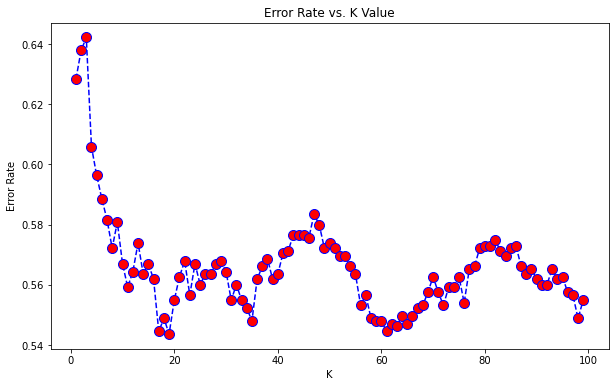

In [32]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

The values with the lowest error rate seems to congregate around 10-20. So we choose n_neighbors=18

In [33]:
knn2 = KNeighborsClassifier(n_neighbors=18)  
knn2 = knn2.fit(X2_train, y2_train)             
kscore2 = knn2.score(X2_test, y2_test)                  
print('KNN fit score of test data is '+str(kscore2))

KNN fit score of test data is 0.4511668107173725


In [34]:
test_preds2 = knn2.predict(X2_test)
mse2 = mean_squared_error(y2_test, test_preds2)
rmse2 = sqrt(mse2)
print('R-squared: '+str(kscore2))
print('RMSE for test data. \n')
print('RMSE: '+ str(round(rmse2,5)))

R-squared: 0.4511668107173725
RMSE for test data. 

RMSE: 1.32426


                  Night_pred  Morning_pred  Afternoon_pred  Evening_pred
Actual_Night               5             0              36           119
Actual_Morning             4             1              46            67
Actual_Afternoon           4             2             220           181
Actual_Evening            14             3             159           296
              precision    recall  f1-score   support

           1       0.19      0.03      0.05       160
           2       0.17      0.01      0.02       118
           3       0.48      0.54      0.51       407
           4       0.45      0.63      0.52       472

    accuracy                           0.45      1157
   macro avg       0.32      0.30      0.27      1157
weighted avg       0.39      0.45      0.40      1157



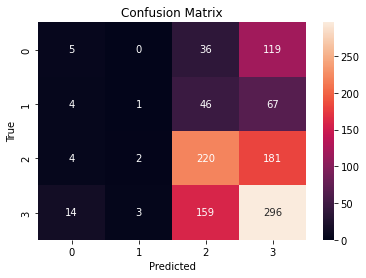

In [37]:
y2_test_pred = knn2.predict(X2_test) #the predicted values
kcmat2 = confusion_matrix(y2_test, y2_test_pred) #creates a "confusion matrix"
sns.heatmap(kcmat2, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
conf_matrix2 = pd.DataFrame(kcmat2, index=['Actual_Night','Actual_Morning','Actual_Afternoon','Actual_Evening'], columns = ['Night_pred','Morning_pred','Afternoon_pred','Evening_pred']) 
print(conf_matrix2)
print(classification_report(y2_test,y2_test_pred, zero_division=0))


**Observation** <br>
The second run of the KNeighborsClassifier model has an accuracy of 0.4511 implying it can predict the label of a track correctly 45.11% of the time. Precision per y-label (night, morning,afternoon, evening) is low from 0.17 to 0.48 indicates that 17% to 48%  of predicted tracks' play time are correctly predicted. Recall looks low as well, with a range of 0.01 to 0.63 indicating that 1% to 63% of the track-play time is predicted correctly with the KNN model. <br> <br>

Compared with the first run of the KNN model, this second run has a lower accuracy, 0.4650 (trial 1) vs. 0.4511 (trial 2), same precision and a lower recall (0.46 vs 0.45). Adding the column did not improve the accuracy of the KNN model. <br>

We will now try to see how a Random Forest Classifier performs with my data. <br>

## RandomForestClassifier Trial 2

Recreate the training and test set with a 70% training and 30% test set. StandardScaler is set to ensure that the dataset is scaled prior to running the model <br>
GridSearchCV is run with the same dataset parameters to determine the best parameters to produce the best accuracy value. 

In [38]:
X2 = df2.drop('time_of_day',axis=1)
feature_names = X2.columns.tolist()
y2 = df2['time_of_day'].astype(int)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y,random_state=40)

# use standard scaler to scale the data
scaler = StandardScaler()
scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)

In [39]:
forest2 = RandomForestClassifier(bootstrap=True,criterion='entropy',max_depth=14,max_features=None,n_estimators=200,oob_score=True,random_state=40,warm_start=True)

forest2.fit(X2_train, y2_train)
y2_pred_test = forest2.predict(X2_test)
score = accuracy_score(y2_test, y2_pred_test)
print('Random Forest Classifier Accuracy Score for the 2nd trial: '+str(score))

Random Forest Classifier Accuracy Score for the 2nd trial: 0.9101123595505618


In [40]:
print('R-squared: '+str(score))
y2pred = forest2.predict(X2_test)
rmse2 = sqrt(mean_squared_error(y2_test, y2_pred_test))
print("RMSE: ", rmse2) 

R-squared: 0.9101123595505618
RMSE:  0.5842945942423625


              precision    recall  f1-score   support

           1       0.94      0.75      0.84       155
           2       0.92      0.89      0.90       116
           3       0.93      0.91      0.92       400
           4       0.89      0.96      0.92       486

    accuracy                           0.91      1157
   macro avg       0.92      0.88      0.90      1157
weighted avg       0.91      0.91      0.91      1157



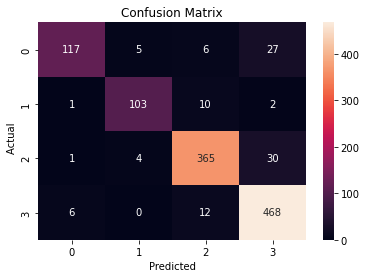

In [41]:
cmat2 = confusion_matrix(y2_test, y2_pred_test)
sns.heatmap(cmat2, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual    ')
print(classification_report(y2_test,y2_pred_test, zero_division=0))

conf_matrix2 = pd.DataFrame(cmat2, index=['Actual_Night','Actual_Morning','Actual_Afternoon','Actual_Evening'], columns = ['Night_pred','Morning_pred','Afternoon_pred','Evening_pred']) 
#print(conf_matrix2)
#print(classification_report(y2_test,y2_test_pred, zero_division=0))

**Observations:**
For the second run of the Random Forest Classifier model, the accuracy has improved. R-squared indicates that we can explain 91.01% of the variation of the model. RMSE indicates that the model's prediction is off by 0.5843 <br>

Precision per y-label (night, morning,afternoon, evening) is now 0.89 to 0.94 indicates that 89% to 94%  of predicted tracks' play time are correctly predicted. Recall is now within the range of 0.75 to 0.96 indicating that 75% to 96% of the track-play time is predicted correctly with the KNN model. <br> 

This is a significant increase in all pertinent metrics compared to the metrics of the first run. <br>

The summary of the model's performance on the second run below: <br>
<table >
<tr><th>Classifier Models<th><th> R2 <th><th> RMSE  <th><th> Precision/Recall Weighted Avg<tr><tr>
<tr><td> KNeighborsClassifier <td><td> 0.4512 <td><td> 1.3243 <td><td> 0.39/0.45 <td><tr>
<tr><td> RandomForestClassifier <td><td> 0.9101 <td><td> 0.5843 <td><td> 0.91/0.91<td><tr>
<table>

Try and visualize the Random Forest Tree for the second run of the RandomForestClassifier model 

In [42]:
from sklearn import tree
fn=feature_names
#cn=target_names
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=800)
tree.plot_tree(forest.estimators_[0], max_depth=14,filled = True);
fig.savefig('rfclassifier_individualtree.png')

##  <font color='blue'> 6. Conclusion <font>

#### Visualizations shows that I listen to music mostly in the afternoon and evening, with increasing valence, energy, danceability, loudness from after midnight until the afternoon. <br>
With the prediction model, both models KNN (K-NeighborClassifier) and RFC (RandomForestClassifier) did not perform well with the first dataset that consists of audio-analytics as independent variables (X) and track play time label as dependent variable (Y). Accuracy score for both KNN and RFC is always less than 0.50 even if tuning is implemented. 
<br>
Since the accuracy is low, we attempted to add more columns to the dataset to see if an increase in accuracy can be achieved. <br>
<br>
For the second run with the additional column (date and time when tracks are played), the KNN model's performance has degraded slightly (both in accuracy score and recall metrics). However, the RFC model's accuracy has increased significantly from 0.43 to 0.91. The precision and recall has increased as well from 0.41/0.43 to 0.91/0.91 weighted average. This is very much preferab
